In [184]:
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

In [172]:

# Premier_league - E0, La_liga - SP1, Ligue_1 - F1, Serie_A - I1
league_name, code = "Premier_league", "E0"
FIRST_SEASON_YEAR, LAST_SEASON_YEAR = 5, 23

In [173]:
#Last number of seaseons to calculate new features
N = 5
#Important columns
selected_columns = [
    'Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HY', 'AY', 'HR', 'AR',
    f'HPTS_avg_{N}', f'APTS_avg_{N}', f'H_gd_{N}', f'A_gd_{N}', f'H_eff_{N}', f'A_eff_{N}', f'HST_avg_{N}', f'AST_avg_{N}', 'target'
]
# Creating folder if not exist
output_folder = f"dataset/processed/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [174]:
#Complete with your needs
TEAMS_IN_LEAGUE = 20

# Creating target column: 0 - Home_Team loss, 1 - Home_Team win, 2 - draw
def data_cleaner(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy["target"] = np.where(df_copy["FTR"] == "H", 0, np.where(df_copy["FTR"] == "A", 2, 1))
    return df_copy


In [175]:
#Feature engineering functions
def find_season_name(season_start_year: int, league_code: str):
    if season_start_year < 9:
        return f"{league_code}_0{season_start_year}_0{season_start_year + 1}"
    elif season_start_year == 9:
        return f"{league_code}_0{season_start_year}_{season_start_year + 1}"
    else:
        return f"{league_code}_{season_start_year}_{season_start_year+ 1}"

def get_all_team_matches(df: pd.DataFrame, name: str):
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    HT_matches = df.groupby("HomeTeam")
    AT_matches = df.groupby("AwayTeam")

    all_team_matches = pd.concat([HT_matches.get_group(name), AT_matches.get_group(name)])
    all_team_matches.sort_values(by="Date", inplace=True)
    return all_team_matches

def calculate_final_table(df: pd.DataFrame):
    team_points = {}

    for _, row in df.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        ftr = row['FTR']

        if home_team not in team_points:
            team_points[home_team] = 0
        if away_team not in team_points:
            team_points[away_team] = 0

        if ftr == 'H':
            team_points[home_team] += 3
        elif ftr == 'A':
            team_points[away_team] += 3
        elif ftr == 'D':
            team_points[home_team] += 1
            team_points[away_team] += 1

    points_df = pd.DataFrame(list(team_points.items()), columns=['Team', 'Points'])
    sorted_points_df = points_df.sort_values(by='Points', ascending=False).reset_index(drop=True)

    return sorted_points_df

def get_team_total_points(df: pd.DataFrame, team: str):
    final_table = calculate_final_table(df)
    team_row = final_table.loc[final_table['Team'] == team, 'Points']
    return team_row.values[0] if not team_row.empty else -1
        
def get_team_avg_points(df: pd.DataFrame, team: str):
    N = (TEAMS_IN_LEAGUE - 1) * 2 
    final_table = calculate_final_table(df)
    team_row = final_table.loc[final_table['Team'] == team, 'Points']
    return np.round(team_row.values[0] / N, 2) if not team_row.empty else -1
        
def get_team_position(df: pd.DataFrame, team: str):
    final_table = calculate_final_table(df)
    team_row = final_table.loc[final_table['Team'] == team]
    return int(team_row.index[0] + 1 if not team_row.empty else -1)

def is_team_newcomer(last_season_df: pd.DataFrame, current_season_df: pd.DataFrame, team: str):
    last_season_table, current_season_table = calculate_final_table(last_season_df), calculate_final_table(current_season_df)
    return team in current_season_table['Team'].values and team not in last_season_table['Team'].values

def find_newcomer_teams_statistics(last_season_df: pd.DataFrame, current_season_df: pd.DataFrame):
    last_season_table, current_season_table = calculate_final_table(last_season_df), calculate_final_table(current_season_df)
    newcomer_teams = [team for team in list(current_season_table['Team']) if team not in list(last_season_table['Team'])]
    return { 
        name : { 
            'Points': get_team_total_points(current_season_df, name), 
            'Avg': get_team_avg_points(current_season_df, name),
            'Position': get_team_position(current_season_df, name)
        } for name in newcomer_teams
    }

def find_all_newjoiners(seasons_file_name: list[str], league_name: str):
    newjoiners_all, processed_data = [], []
    
    for i in range(1, len(seasons_file_name)):
        last_season = pd.read_csv(f"dataset/{league_name}/{seasons_file_name[i-1]}")
        curr_season = pd.read_csv(f"dataset/{league_name}/{seasons_file_name[i]}")
        curr_newjoiners_stats = find_newcomer_teams_statistics(last_season, curr_season)
        newjoiners_all.append(curr_newjoiners_stats)
    
    for season, newcomers in enumerate(newjoiners_all, start=2005):
        short_season = f"{season % 100:02d}/{(season % 100) + 1:02d}"
        for team, stats in newcomers.items():
            processed_data.append({'Season': short_season, 'Team': team, **stats})

    return pd.DataFrame(processed_data)

def calc_HT_cards(df: pd.DataFrame, card = 'Y', N = 9):
    cards_results = {i: { 'wins': 0, 'losses': 0, 'draws': 0 } for i in range(1, N)}

    if card not in ['Y', 'R']:
        raise ValueError("Argument 'card' must be 'Y' or 'R'.")

    for _, row in df.iterrows():
        for num in range(1, N):
            if num == row[f'H{card}']:
                if row['FTHG'] > row['FTAG']:
                    cards_results[num]['wins'] += 1
                elif row['FTHG'] == row['FTAG']:
                    cards_results[num]['draws'] += 1
                else:
                    cards_results[num]['losses'] += 1

    return cards_results


def calc_AT_cards(df: pd.DataFrame, card = 'Y', N = 9):
    cards_results = {i: { 'wins': 0, 'losses': 0, 'draws': 0 } for i in range(1, N)}

    if card not in ['Y', 'R']:
        raise ValueError("Argument 'card' must be 'Y' or 'R'.")

    for _, row in df.iterrows():
        for num in range(1, N):
            if num == row[f'A{card}']:
                if row['FTAG'] > row['FTHG']:
                    cards_results[num]['wins'] += 1
                elif row['FTHG'] == row['FTAG']:
                    cards_results[num]['draws'] += 1
                else:
                    cards_results[num]['losses'] += 1

    return cards_results


def count_results(df: pd.DataFrame):
    home_wins, away_wins, draws = 0, 0, 0
    
    for _, row in df.iterrows():
        result = row['FTR']
        if result == 'H':
            home_wins += 1
        elif result == 'A':
            away_wins += 1
        elif result == 'D':
            draws += 1
    
    return home_wins, away_wins, draws

def count_seasons_per_team(df: pd.DataFrame):
    team_seasons = {}
    
    for _, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        date = pd.to_datetime(row['Date'], format='%d/%m/%y')
        
        season_start = date.month
        season_end = 5 if date.month <= 5 else 6
        
        if season_start <= date.month <= season_end:
            season = f"{date.year - 1}/{date.year}"
        else:
            season = f"{date.year}/{date.year + 1}"
        
        if home_team in team_seasons:
            team_seasons[home_team].add(season)
        else:
            team_seasons[home_team] = {season}
        
        if away_team in team_seasons:
            team_seasons[away_team].add(season)
        else:
            team_seasons[away_team] = {season}
    
    result = {team: len(seasons) for team, seasons in team_seasons.items()}
    return result

In [176]:
NEWJOINER_AVG_POINTS = 1.05

cols = ["HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC", "HY", "AY"]

def calc_curr_team_goal_difference(df: pd.DataFrame, window=5):
    df_copy = df.copy()
    HT_goals_scored = df_copy.groupby('HomeTeam')['FTHG'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    HT_goals_conceded = df_copy.groupby('HomeTeam')['FTAG'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df_copy[f"H_gd_{window}"] = (HT_goals_scored - HT_goals_conceded)

    AT_goals_scored = df_copy.groupby('AwayTeam')['FTAG'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    AT_goals_conceded = df_copy.groupby('AwayTeam')['FTHG'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df_copy[f"A_gd_{window}"] = (AT_goals_scored - AT_goals_conceded)

    return df_copy

def calc_effectivnes_team(df: pd.DataFrame, window=5):
    df_copy = df.copy()
    HT_goals_scored = df_copy.groupby('HomeTeam')['FTHG'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    HT_shots_target = df_copy.groupby('HomeTeam')['HST'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df_copy[f"H_eff_{window}"] = np.where(HT_shots_target != 0, np.round((HT_goals_scored / HT_shots_target), 2), 0)

    AT_goals_scored = df_copy.groupby('AwayTeam')['FTAG'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    AT_shots_target = df_copy.groupby('AwayTeam')['AST'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df_copy[f"A_eff_{window}"] = np.where(AT_shots_target != 0, np.round((AT_goals_scored / AT_shots_target), 2), 0)

    return df_copy

def calc_curr_mean_statistic(df: pd.DataFrame, cols: list[str], window=5):
    df_copy = df.copy()
    for col in cols:
        rolling_col_name = col + '_avg' + f'_{window}'
        team_col = 'HomeTeam' if col[0] == 'H' else 'AwayTeam'

        rolling_value = df_copy.groupby(team_col)[col].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
        df_copy[rolling_col_name] = np.round(rolling_value, 2).fillna(0)

    return df_copy

def calc_avg_points(df: pd.DataFrame, window=5):
    df_copy = df.copy()

    df_copy['HT_Points'] = df_copy['FTR'].apply(lambda x: 3 if x == 'H' else 1 if x == 'D' else 0)
    df_copy['AT_Points'] = df_copy['FTR'].apply(lambda x: 3 if x == 'A' else 1 if x == 'D' else 0)

    df_copy['Cumulative_Points_Home'] = df_copy.groupby('HomeTeam')['HT_Points'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df_copy['Cumulative_Matches_Home'] = df_copy.groupby('HomeTeam')['HT_Points'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).count())
    df_copy[f'HPTS_avg_{window}'] = np.round((df_copy['Cumulative_Points_Home'] / df_copy['Cumulative_Matches_Home']), 2)

    df_copy['Cumulative_Points_Away'] = df_copy.groupby('AwayTeam')['AT_Points'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    df_copy['Cumulative_Matches_Away'] = df_copy.groupby('AwayTeam')['AT_Points'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).count())
    df_copy[f'APTS_avg_{window}'] = np.round((df_copy['Cumulative_Points_Away'] / df_copy['Cumulative_Matches_Away']), 2)

    df_copy = df_copy.drop(['HT_Points', 'AT_Points', 'Cumulative_Points_Home', 'Cumulative_Matches_Home', 'Cumulative_Points_Away', 'Cumulative_Matches_Away'], 
                           axis=1, errors='ignore')

    return df_copy

# All neccesary functions to transform data combined
def data_transformation(df: pd.DataFrame, cols: list[str], window=5):
    df_copy = df.copy()
    df_copy = calc_avg_points(df_copy, window)
    df_copy = calc_curr_team_goal_difference(df_copy, window)
    df_copy = calc_effectivnes_team(df_copy, window)
    df_copy = calc_curr_mean_statistic(df_copy, cols, window)
    df_copy = data_cleaner(df_copy)
    return df_copy

def calc_team_status(current_season_df: pd.DataFrame, last_seaons_df: list[pd.DataFrame], team: str):
    N = (TEAMS_IN_LEAGUE - 1) * 2

    if is_team_newcomer(current_season_df, last_seaons_df[0], team):
        return NEWJOINER_AVG_POINTS
    else:
        points_counter, seasons_in_league = 0, 0
        for previous_season in last_seaons_df:
            final_table = calculate_final_table(previous_season)
            if team in final_table['Team'].values:
                points_counter += final_table.loc[final_table['Team'] == team, 'Points'].values[0]
                seasons_in_league += 1 

        return np.round(points_counter / (N * seasons_in_league), 2) if seasons_in_league > 0 else 0
    
def create_teams_status_dict(current_season_df: pd.DataFrame, last_seasons_df: list[pd.DataFrame]):
    teams = set(current_season_df['HomeTeam'])
    return { team: calc_team_status(current_season_df, last_seasons_df, team) for team in teams }

def calc_h2h_stats(current_season_df: pd.DataFrame, last_seasons_df: list[pd.DataFrame]):
    curr_df = current_season_df.copy()
    curr_df['H_H2H'], curr_df['A_H2H'] = 0, 0

    for index, row in curr_df.iterrows():
        team_H, team_A = row['HomeTeam'], row['AwayTeam']

        matches = pd.concat([df[((df['HomeTeam'] == team_A) & (df['AwayTeam'] == team_H)) | 
                                ((df['HomeTeam'] == team_H) & (df['AwayTeam'] == team_A))] for df in last_seasons_df])
        
        if not matches.empty:
            points_A = (3 * len(matches[(matches['HomeTeam'] == team_A) & (matches['FTR'] == 'H')]) + 
                        3 * len(matches[(matches['AwayTeam'] == team_A) & (matches['FTR'] == 'A')]) + 
                        len(matches[((matches['HomeTeam'] == team_A) | (matches['AwayTeam'] == team_A)) & (matches['FTR'] == 'D')]))

            points_H = (3 * len(matches[(matches['HomeTeam'] == team_H) & (matches['FTR'] == 'H')]) + 
                        3 * len(matches[(matches['AwayTeam'] == team_H) & (matches['FTR'] == 'A')]) + 
                        len(matches[((matches['HomeTeam'] == team_H) | (matches['AwayTeam'] == team_H)) & (matches['FTR'] == 'D')]))

            curr_df.at[index, 'H_H2H'] = np.round(points_H / matches.shape[0], 2)
            curr_df.at[index, 'A_H2H'] = np.round(points_A / matches.shape[0], 2)   
        else:
            curr_df.at[index, 'H_H2H'] = NEWJOINER_AVG_POINTS if is_team_newcomer(current_season_df, last_seasons_df[0], team_H) else calc_team_status(current_season_df, last_seasons_df, team_H)
            curr_df.at[index, 'A_H2H'] = NEWJOINER_AVG_POINTS if is_team_newcomer(current_season_df, last_seasons_df[0], team_A) else calc_team_status(current_season_df, last_seasons_df, team_A)

    return curr_df

In [177]:
#Merge Seasons Main Functions
def merge_all_seasons(file_names, selected_columns, output_folder, N):
    merged_df = pd.DataFrame()

    for i in range(len(file_names)):
        current_basic_df = pd.read_csv(f"dataset/{league_name}/{file_names[i]}.csv")
        current_transformed_df = data_transformation(current_basic_df, ["HST", "AST"], window=N)
        current_df = current_transformed_df[selected_columns].copy()  

        if i > 2:
            last_seasons = [pd.read_csv(f"dataset/{league_name}/{file_names[j]}.csv") for j in range(i-3, i)]
            teams_status_dict = create_teams_status_dict(current_df, last_seasons)
            current_df['H_status'] = current_df['HomeTeam'].apply(lambda team: teams_status_dict.get(team))
            current_df['A_status'] = current_df['AwayTeam'].apply(lambda team: teams_status_dict.get(team))

            current_df = calc_h2h_stats(current_df, last_seasons)

        merged_df = pd.concat([merged_df, current_df], ignore_index=True)

    output_file = os.path.join(output_folder, f"{code}_seasons_{FIRST_SEASON_YEAR}_to_{LAST_SEASON_YEAR}.csv")
    merged_df.to_csv(output_file, index=False)
    print(f"Merged data saved to {output_file}")

In [178]:
file_names_to_merge = [f"{code}_{str(year).zfill(2)}_{str(year+1).zfill(2)}" for year in range(FIRST_SEASON_YEAR, LAST_SEASON_YEAR)]
merge_all_seasons(file_names_to_merge, selected_columns, output_folder, N)

/var/folders/0l/smrm8y8s5xb1sfvbty2kj2_40000gn/T/ipykernel_4610/996263460.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  curr_df.at[index, 'H_H2H'] = np.round(points_H / matches.shape[0], 2)
/var/folders/0l/smrm8y8s5xb1sfvbty2kj2_40000gn/T/ipykernel_4610/996263460.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  curr_df.at[index, 'A_H2H'] = np.round(points_A / matches.shape[0], 2)
/var/folders/0l/smrm8y8s5xb1sfvbty2kj2_40000gn/T/ipykernel_4610/996263460.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a comp

Merged data saved to dataset/processed/E0_seasons_5_to_23.csv


In [180]:
# Loading seasons file
file = 'E0_seasons_5_to_23'
seasons = pd.read_csv(f'dataset/processed/{file}.csv')
seasons = data_cleaner(seasons)
seasons.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HY,AY,HR,AR,HPTS_avg_5,APTS_avg_5,H_gd_5,A_gd_5,H_eff_5,A_eff_5,HST_avg_5,AST_avg_5,target,H_status,A_status,H_H2H,A_H2H
0,E0,13/08/05,Aston Villa,Bolton,2,2,D,2,2,D,3,13,2,6,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,NaN,NaN,NaN,NaN
1,E0,13/08/05,Everton,Man United,0,2,A,0,1,A,10,12,5,5,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2,NaN,NaN,NaN,NaN
2,E0,13/08/05,Fulham,Birmingham,0,0,D,0,0,D,15,7,7,4,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,NaN,NaN,NaN,NaN
3,E0,13/08/05,Man City,West Brom,0,0,D,0,0,D,15,13,8,3,2,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,NaN,NaN,NaN,NaN
4,E0,13/08/05,Middlesbrough,Liverpool,0,0,D,0,0,D,4,16,2,7,2,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,NaN,NaN,NaN,NaN


In [183]:
seasons.shape
seasons.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HY,AY,HR,AR,HPTS_avg_5,APTS_avg_5,H_gd_5,A_gd_5,H_eff_5,A_eff_5,HST_avg_5,AST_avg_5,target,H_status,A_status,H_H2H,A_H2H
count,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.00000,6840.000000,6840.000000,6840.000000,6840.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6480.000000,6840.000000,6840.000000,6840.000000,5700.000000,5700.000000,5700.000000,5700.000000
mean,1.531287,1.171053,0.687281,0.516082,13.751754,10.994298,5.912865,4.69152,1.473684,1.769006,0.059211,0.082895,1.610315,1.146387,1.597685,-1.581327,0.273790,0.260562,5.559770,4.433819,0.837719,1.302067,1.302067,1.245409,1.245409
std,1.315508,1.159326,0.840217,0.732572,5.423469,4.730472,3.334105,2.80181,1.201893,1.279315,0.245152,0.286152,0.769312,0.755339,4.724060,4.628691,0.132066,0.140459,2.684406,2.087524,0.854862,0.573881,0.573881,0.821751,0.821751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-21.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,3.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.600000,-1.000000,-5.000000,0.180000,0.170000,3.800000,3.200000,0.000000,1.080000,1.080000,0.670000,0.670000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,5.000000,4.00000,1.000000,2.000000,0.000000,0.000000,1.600000,1.000000,1.000000,-2.000000,0.260000,0.250000,5.400000,4.330000,1.000000,1.260000,1.260000,1.250000,1.250000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.00000,2.000000,3.000000,0.000000,0.000000,2.200000,1.600000,4.000000,1.000000,0.350000,0.330000,7.200000,5.600000,2.000000,1.692500,1.692500,1.830000,1.830000
max,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.00000,7.000000,9.000000,2.000000,2.000000,3.000000,3.000000,21.000000,16.000000,1.500000,1.000000,21.000000,13.000000,2.000000,2.450000,2.450000,3.000000,3.000000


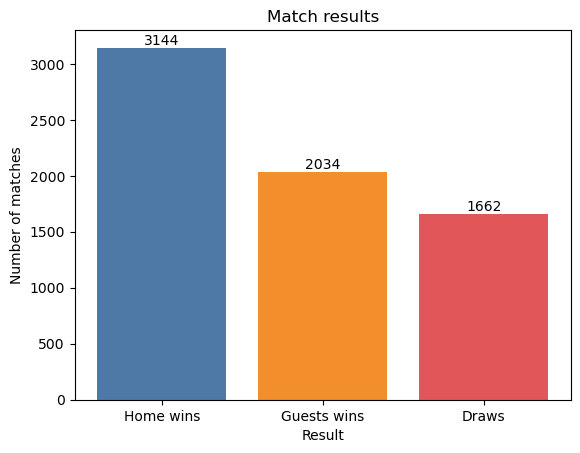

In [187]:
home_wins, away_wins, draws = count_results(seasons)

labels = ['Home wins', 'Guests wins', 'Draws']
results = [home_wins, away_wins, draws]

for i in range(len(labels)):
    plt.text(i, results[i] + 0.1, str(results[i]), ha='center', va='bottom')

plt.bar(labels, results, color=['#4e79a7', '#f28e2b', '#e15759'])
plt.title('Match results')
plt.xlabel('Result')
plt.ylabel('Number of matches')
plt.show()

In [ ]:
# Cards impact analysis
HT_results = calc_HT_cards(seasons, card='R', N=3)
AT_results = calc_AT_cards(seasons, card='R', N=3)

categories_one = ['HT 1 card', 'AT 1 card']
categories_two = ['HT 2 cards', 'HT 2 cards']

wins_1_card = [HT_results[1]['wins'], AT_results[1]['wins']]
losses_1_card = [HT_results[1]['losses'], AT_results[1]['losses']]
draws_1_card = [HT_results[1]['draws'], AT_results[1]['draws']]

wins_2_card = [HT_results[2]['wins'], AT_results[2]['wins']]
losses_2_card = [HT_results[2]['losses'], AT_results[2]['losses']]
draws_2_card = [HT_results[2]['draws'], AT_results[2]['draws']]

# Parameters
bar_width = 0.2
index = np.arange(len(categories_one))
colors = ['#4e79a7', '#f28e2b', '#e15759']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

bar1 = ax1.bar(index - bar_width, wins_1_card, bar_width, label='wins', color=colors[0])
bar2 = ax1.bar(index, losses_1_card, bar_width, label='losses', color=colors[1])
bar3 = ax1.bar(index + bar_width, draws_1_card, bar_width, label='draws', color=colors[2])
ax1.set_xlabel('Team')
ax1.set_ylabel('Number of matches')
ax1.set_title('The impact of 1 red card on the march result')
ax1.set_xticks(index)
ax1.set_xticklabels(categories_one)
ax1.legend()

bar1 = ax2.bar(index - bar_width, wins_2_card, bar_width, label='wins', color=colors[0])
bar2 = ax2.bar(index, losses_2_card, bar_width, label='losses', color=colors[1])
bar3 = ax2.bar(index + bar_width, draws_2_card, bar_width, label='draws', color=colors[2])
ax2.set_xlabel('Team')
ax2.set_ylabel('Number of matches')
ax2.set_title('The impact of 2 red cards on the march result')
ax2.set_xticks(index)
ax2.set_xticklabels(categories_two)
ax2.legend()

plt.tight_layout()
plt.show()